I want to turn the Binary Search Notebook into a real .py class that I could run just from the terminal. This will probably make it run faster and be a lot easier to share with others and hopefully solve some of the problems I've been having with turning it into a bunch of indivisual .py files. See the "Second data set" notebook for the problems. 

In [33]:
pwd

'/home/cody/Binary Search'

In [2]:
%%writefile Binary_Data_Clean.py
from astropy.table import Table, Column
from astropy.io import fits
import numpy as np
import astropy.units as u
from astropy.constants import G, sigma_sb, c
class Binary_Data_Clean:
    """
    Goal of this class is it have all of the data simplifying stuff
    in one place. The process should go as follows,
    1.  Import the fits files and make them an astropy Tables. There should be an all visit table, and an 
        all averaged tables.
    
    2.  Make a cut so that we only have stars with at least 5 observations. This should eliminate rows in
        both the all visit and all average tables
    
    3.  Add the RV measurments, RV errors, and the dates observed as a column of arrays to the all average
        table. This way I don't need to have both tables around anymore I can just use the averaged table.
        
    4.  Make a cut so that I only have stars that fall into the red giant branch.
    
    5.  Use Isochrone tables to find the mass and luminocity of the stars based off the effective surface 
        tempurature, surface gravity and iron ratios
    """
    
    #Initialize, with two paths to the files I want to read in
    def __init__(self, all_average_path, all_visit_path, iso_path):
        self.all_average_path = all_average_path
        self.all_visit_path = all_visit_path
        self.iso_path = iso_path
    #Reads in the tables 
    def load_tables(self):
        ALL_AVERAGE = Table(fits.getdata(self.all_average_path,1))
        ALL_VISIT = Table(fits.getdata(self.all_visit_path, 1))
        ISO = Table(fits.getdata(self.iso_path,1))

        return ALL_AVERAGE, ALL_VISIT, ISO
    
    #There are some points that have unphysical velocities, so lets get rid of them
    def too_fast(self,ALL_VISIT):
        ALL_VISIT = ALL_VISIT[np.isfinite(ALL_VISIT['VHELIO'])]
        return ALL_VISIT[ALL_VISIT['VHELIO'] < 10**4]
        
    #Makes the cuts for number of visits must be greater than 5
    def nvisits_cut(self,ALL_AVERAGE,ALL_VISIT):
        #I want to make copies of the table so that when I make changes to them it doesn't affect the original tables
        ALL_AVERAGE_SIMPLIFIED = Table(ALL_AVERAGE, copy = True)
        ALL_VISIT_SIMPLIFIED = Table(ALL_VISIT, copy = True)
        rows_remove = []
        for n in range(len(ALL_AVERAGE_SIMPLIFIED)):
            if ALL_AVERAGE_SIMPLIFIED['NVISITS'][n] < 5:
                rows_remove.append(n)
        ALL_AVERAGE_SIMPLIFIED.remove_rows(rows_remove)
        
        holder = []
        
        #TO DO: Figure out how to get rid of this nested for loop. This is THE bottle neck for the whole process
        for n in range(len(ALL_VISIT_SIMPLIFIED)):
            for m in ALL_AVERAGE_SIMPLIFIED['APOGEE_ID']:
                if ALL_VISIT_SIMPLIFIED["APOGEE_ID"][n] == m:
                    holder.append(n)
                    break
        #Holder is a list of all the rows I want to keep. So I need to get rid of all the other ones
        remove_allvis = []
        dumby_allvis = list(range(0,len(ALL_VISIT_SIMPLIFIED)))
        for x in dumby_allvis:
            if x not in holder:
                remove_allvis.append(dumby_allvis[x])
                
        ALL_VISIT_SIMPLIFIED.remove_rows(remove_allvis)
        return ALL_AVERAGE_SIMPLIFIED, ALL_VISIT_SIMPLIFIED
    
    #Make a separate red giant table.
    def rg_cut(self,AllAvg):
        AllAvgSimp_foo = Table(AllAvg, copy = True)
        #Get rid of bad tempurature and log(g) values. 
        AllAvgSimp_foo['TEFF'][AllAvgSimp_foo['TEFF'] < 0 ] = np.nan #replaces bad values with nan
        AllAvgSimp_foo['LOGG'][AllAvgSimp_foo['LOGG'] < 0 ] = np.nan
        AllAvgSimp_foo['FE_H'][AllAvgSimp_foo['FE_H'] < -100] = np.nan


        AllAvgSimp_foo = AllAvgSimp_foo[np.isfinite(AllAvgSimp_foo['TEFF'])] #gets rid of nan's
        AllAvgSimp_foo = AllAvgSimp_foo[np.isfinite(AllAvgSimp_foo['LOGG'])]
        AllAvgSimp_foo = AllAvgSimp_foo[np.isfinite(AllAvgSimp_foo['FE_H'])]
        # I only want to look at the Red Giant group right now so I'm going to ignore
        AAS_RG = Table(AllAvgSimp_foo, copy = True)
        AAS_RG['TEFF'][AAS_RG['TEFF'] >= 5500  ] = np.nan 
        AAS_RG['LOGG'][AAS_RG['LOGG'] >= 3.7 + 0.1*AAS_RG['FE_H'] ] = np.nan

        #Now get rid of nan's
        AAS_RG = AAS_RG[np.isfinite(AAS_RG['TEFF'])] #gets rid of nan's
        AAS_RG = AAS_RG[np.isfinite(AAS_RG['LOGG'])]

        # Down the road we'll also have problems with AK and K so we need to get rid of any AK values that are -9999.9999
        AAS_RG['AK_WISE'][AAS_RG['AK_WISE'] < 0  ] = np.nan #replaces bad values with nan
        AAS_RG = AAS_RG[np.isfinite(AAS_RG['AK_WISE'])]

        AAS_RG['AK_TARG'][AAS_RG['AK_TARG'] < 0  ] = np.nan #replaces bad values with nan
        AAS_RG = AAS_RG[np.isfinite(AAS_RG['AK_TARG'])]
        return AAS_RG
        
    
    #Adding the RV, err, and dates to ALL_AVERAGE_SIMPLIFIED. This should be the last one you
    #run because you don't want to waist time adding RV values for stars you will end up ignoring
    def rv_table_add(self, ALL_AVERAGE_SIMPLIFIED, ALL_VISIT_SIMPLIFIED):
        RV_Column = Column(name = 'RADIALV', data = np.ones(len(ALL_AVERAGE_SIMPLIFIED)), dtype = 'object') #Right now filling it with ones just as a place holder
        ERR_Column = Column(name = 'RADIAL_ERR', data = np.ones(len(ALL_AVERAGE_SIMPLIFIED)), dtype = 'object')
        DATE_Column = Column(name = 'RADIAL_DATE', data = np.ones(len(ALL_AVERAGE_SIMPLIFIED)), dtype = 'object')
        
        ALL_AVERAGE_SIMPLIFIED_foo = Table(ALL_AVERAGE_SIMPLIFIED, copy = True)
        ALL_AVERAGE_SIMPLIFIED_foo.add_columns([RV_Column,ERR_Column,DATE_Column], [0,0,0])
        
        start = 0
        end = 0
        loop = 0
        name = 0
        #Just in case I want to organize by APOGEE_ID and JD
        ALL_VISIT_SIMPLIFIED.sort(['APOGEE_ID', 'JD'])
        
        for n in ALL_AVERAGE_SIMPLIFIED_foo['NVISITS']:
            start = end
            end += n
            
            #Read in the dates the object was observed
            Date = ALL_VISIT_SIMPLIFIED['JD'][start:end] - ALL_VISIT_SIMPLIFIED['JD'][start]
            Date_Array = np.array(Date)
            
            RV = ALL_VISIT_SIMPLIFIED['VHELIO'][start:end]
            RV_Array = np.array(RV)
            
            err = ALL_VISIT_SIMPLIFIED['VRELERR'][start:end]
            
            err = [.1 if n < 0.1 else n for n in err]
            err_Array = np.array(err)
            
            #Now Add them to the all averaged simplified table
            ALL_AVERAGE_SIMPLIFIED_foo['RADIALV'][name] = RV_Array
            ALL_AVERAGE_SIMPLIFIED_foo['RADIAL_ERR'][name] = err_Array
            ALL_AVERAGE_SIMPLIFIED_foo['RADIAL_DATE'][name] = Date_Array
            name += 1
        return ALL_AVERAGE_SIMPLIFIED_foo
    
    ### ISOCHRON FITTING ###
    
    def iso_fit(self,ALL_AVERAGE,ISO):
        iso_meanM = np.zeros(len(ALL_AVERAGE))
        iso_medianM = np.zeros(len(ALL_AVERAGE))
        iso_stdM = np.zeros(len(ALL_AVERAGE))
        
        iso_meanL = np.zeros(len(ALL_AVERAGE))
        iso_medianL = np.zeros(len(ALL_AVERAGE))
        iso_stdL = np.zeros(len(ALL_AVERAGE))
        
        for j in range(len(ALL_AVERAGE)):
            star_teff = ALL_AVERAGE['TEFF'][j]
            star_logg = ALL_AVERAGE['LOGG'][j]
            star_feh  = ALL_AVERAGE['FE_H'][j]
            
            gd, = np.where(( (np.abs(ISO['LOGTE']-np.log10(star_teff)) < 0.1) &
                    (np.abs(ISO['LOGG']-star_logg) < 0.1) &
                    (np.abs(ISO['FEH']-star_feh) < 0.1) ) )
            
            # This if loop is to check that any good values got found. If the array is empty then when i find mean and the like
            # it gives me some warnings about dividing by zero. 
            if len(gd) > 0:
                iso_meanM[j] = np.mean(ISO['MASS'][gd])
                iso_medianM[j] = np.median(ISO["MASS"][gd])
                iso_stdM[j] = np.std(ISO["MASS"][gd])

                iso_meanL[j] = np.mean(ISO['LOGL'][gd])
                iso_medianL[j] = np.median(ISO["LOGL"][gd])
                iso_stdL[j] = np.std(ISO["LOGL"][gd])
            else:
                iso_meanM[j] = np.nan
                iso_medianM[j] = np.nan
                iso_stdM[j] = np.nan

                iso_meanL[j] = np.nan
                iso_medianL[j] = np.nan
                iso_stdL[j] = np.nan
        #Now add on the mass luminocity and radius values
        ALL_AVERAGE['ISO_MEANM'] = iso_meanM*u.solMass
        ALL_AVERAGE["ISO_MEDIANM"] = iso_medianM * u.solMass
        ALL_AVERAGE['ISO_STDM'] = iso_stdM * u.solMass

        ALL_AVERAGE['ISO_MEANL'] = iso_meanL * u.solLum
        ALL_AVERAGE["ISO_MEDIANL"] = iso_medianL * u.solLum
        ALL_AVERAGE['ISO_STDL'] = iso_stdL * u.solLum 

        iso_meanR = np.sqrt( ALL_AVERAGE['ISO_MEANL'] / (4 * np.pi * sigma_sb * (ALL_AVERAGE["TEFF"]*u.K)**4 ) ).to(u.solRad)
        ALL_AVERAGE['ISO_MEANR'] = iso_meanR
        ALL_AVERAGE = ALL_AVERAGE[np.isfinite(ALL_AVERAGE['ISO_MEANM'])]
        return ALL_AVERAGE
    
    #Lastly I want to be able to split the data table into the LMC and the SMC. One program with a flag should be able to do it
    def mc_cut(self, ALL_AVERAGE, flag):
        if flag != "L" and flag != 'S':
            return print("ERROR: flag needs to be a string, either 'L' or 'S'")
        ALL_AVERAGE_foo = Table(ALL_AVERAGE, copy = True)
        rows_2_remove = []
        for n in range(len(ALL_AVERAGE_foo)):
            if ALL_AVERAGE_foo['FIELD'][n][0] != flag:
                rows_2_remove.append(n)
        ALL_AVERAGE_foo.remove_rows(rows_2_remove)
    
        return ALL_AVERAGE_foo

Overwriting Binary_Data_Clean.py


In [3]:
%run Binary_Data_Clean.py

In [4]:
Tables = Binary_Data_Clean('/home/cody/Binary Search/2nd_Data_Set/allMC.avg.58247.nocut.fits','/home/cody/Binary Search/2nd_Data_Set/allVisit-t9-l31c-58247.mc.fits',
                          '/home/cody/Binary Search/parsec_decamsdss_all.fits.gz')

In [5]:
AllAvg, AllVis, ISO = Tables.load_tables()

In [6]:
AllVis = Tables.too_fast(AllVis)
AllAvgSimp, AllVisSimp = Tables.nvisits_cut(AllAvg,AllVis)
AAS_RG = Tables.rg_cut(AllAvgSimp)

In [6]:
#Put this later so we can save the LMC and SMC tables
#AllAvgRv = Tables.rv_table_add(AllAvgSimp,AllVisSimp)

In [7]:
AAS_RG_ISO = Tables.iso_fit(AAS_RG, ISO)

In [8]:
AllAvg_LMC = Tables.mc_cut(AAS_RG_ISO, 'L')
AllAvg_SMC = Tables.mc_cut(AAS_RG_ISO, 'S')

Problem with now saving these tables. Becaue one of the rows has a column of type 'object' saving it as a .fits file doesn't work for some reason. So the best I can do is save the simplified tables before they have the RV values added on. 

In [11]:
AllAvg_LMC.write('aas_rgb_lmc_NORV', format = 'fits')
AllAvg_SMC.write('aas_rgb_smc_NORV', format = 'fits')

OSError: File exists: aas_rgb_lmc_NORV

Now that I've saved the LMC and SMC tables I can tack on the RV values

In [9]:
AllAvg_LMC_RV = Tables.rv_table_add(AllAvg_LMC,AllVisSimp)
AllAvg_SMC_RV = Tables.rv_table_add(AllAvg_SMC,AllVisSimp)

In [1]:
%pwd

'/home/cody/Binary Search'

In [47]:
%%writefile Binary_Fraction.py
from astropy.table import Table, Column, vstack
from astropy.io import fits
import numpy as np
from scipy.stats import chi2
import astropy.units as u
from astropy.constants import G, sigma_sb, c

from astropy.time import Time

from thejoker.data import RVData
from twobody.wrap import cy_rv_from_elements
from twobody.utils import ArrayProcessor
from twobody import KeplerOrbit

class Binary_Fraction:
    def __init__(self,AAS_TABLE):
        self.AAS_TABLE = AAS_TABLE
        
    def buddy_values(self, N, m_min):
        """
        Makes a list of the paramiters of the secondary star for the primary star in row 'N' from AAS_TABLE
        
        Inputs
        ----------
        N: This is just the row that I want to use when looking at the AAS_TABLE
        m_min: Minimum mass I want to consider. This should be in Jupiter Masses.
        
        Output
        ----------
        List of the physical paramiters randomly made from the companion star. 
        """
        M = self.AAS_TABLE['ISO_MEANM'][N]*u.solMass
        #Make the fake companion that we want orbiting our primary star
        m_buddy = np.random.uniform(m_min, M.to(u.jupiterMass).value)*u.jupiterMass #For reference the 1 solMas = 1047 jupMas
        #P_buddy = np.random.uniform(12,1000)*u.d
        P_buddy = np.random.lognormal(5.03,2.28)*u.d
        
        if P_buddy.value < 12:
            e_buddy = 0*u.one
        else:
            e_buddy = np.random.uniform(0, 0.93)*u.one
        n_foo = (2 * np.pi) / P_buddy
        
        a_buddy = np.cbrt(( (G*(M + m_buddy)) / (4*np.pi**2) ) * P_buddy**2 )
        a_buddy = a_buddy.to(u.AU)
        
        # Also need some angles of the orbit that we would see. 
        i_buddy = np.random.uniform(0, np.pi)*u.rad
        
         #These are some phase angles that depend on when we first see it.
        w_buddy = np.random.uniform(0, 2*np.pi)*u.rad
        phi_buddy = np.random.uniform(0, 2*np.pi)*u.rad

        #Make sure the closest point of the orbit isn't so close that we have to worry about title effects. 
        r_peri = (1-e_buddy)*a_buddy
        r_peri = r_peri.to(u.solRad)
        
        #If the orbit is so close that we would have to consider title effects then we want to pick a different
        #set of orbital paramiters.
        in_case_of_emergency = 0 #Variable that will get us out of the loop if we're stuck forever
        while r_peri.value < 5*self.AAS_TABLE['ISO_MEANR'][N]:

            m_buddy = np.random.uniform(m_min, M.to(u.jupiterMass).value)*u.jupiterMass 
            P_buddy = np.random.uniform(12,1000)*u.d
            #P_buddy = np.random.lognormal(5.03,2.28)*u.d
            if P_buddy.value < 12:
                e_buddy = 0*u.one
            else:
                e_buddy = np.random.uniform(0,.93)*u.one
            n = (2*np.pi) / P_buddy

            #From those paramiters we can use keplers law to find the semi-major axis
            a_buddy = np.cbrt(( (G*(M + m_buddy)) / (4*np.pi**2) ) * P_buddy**2 )
            a_buddy = a_buddy.to(u.AU)

            # Also need some angles of the orbit that we would see. 
            i_buddy = np.random.uniform(0, np.pi)*u.rad

            #These are some phase angles that depend on when we first see it.
            w_buddy = np.random.uniform(0, 2*np.pi)*u.rad
            phi_buddy = np.random.uniform(0, 2*np.pi)*u.rad
            #Make sure the closest point of the orbit isn't so close that we have to worry about title effects. 
            r_peri = (1-e_buddy)*a_buddy
            r_peri = r_peri.to(u.solRad)
            in_case_of_emergency += 1
            if in_case_of_emergency > 9:
                print("You got stuck!")
                break
        # Now I can find the "K" paramiter based on these values. 
        K_buddy = (m_buddy / (M + m_buddy)) * (n_foo * a_buddy * np.sin(i_buddy)) / np.sqrt(1-e_buddy**2)
        K_buddy = K_buddy.to(u.km / u.s)
        foo_list = [m_buddy, e_buddy, P_buddy, a_buddy, i_buddy, w_buddy,
                   phi_buddy, K_buddy, self.AAS_TABLE['APOGEE_ID'][N]]
        
        return foo_list
    
    def buddy_table(self, buddy_array):
        """
        Takes the output from buddy_values and turns it into an astropy table. The goal is to have a table of
        values from the simulations. Some of 
        """
        Foo_Table = Table([[False], [buddy_array[0].value], [buddy_array[1].value], [buddy_array[2].value], [buddy_array[3].value], 
                           [buddy_array[4].value], [buddy_array[5].value], [buddy_array[6].value], [buddy_array[7].value],
                           [0], [buddy_array[8]]],
                          names = ('Binary','m','e','P','a','i','w','phi','K','P-value','APOGEE_ID'),
                          dtype=('b','f8','f8','f8','f8','f8','f8','f8','f8','f8','str'))
        return Foo_Table

        
    def fake_rv_binary(self, N, m_min, jitter):
        """
        After I have a set of paramiters form the buddy_values I want to make a fake Radial Velocity Measurment
        based on those values and the Primary Stars Values.
        """
        buddy_list = self.buddy_values(N,m_min)
        Date = self.AAS_TABLE['RADIAL_DATE'][N]
        
        if jitter:
            jitter_value = 2*0.015**(1/3*self.AAS_TABLE["LOGG"][N])
            err = (np.sqrt(self.AAS_TABLE['RADIAL_ERR'][N]**2 + jitter_value**2) )*u.km/u.s
        else:
            err = self.AAS_TABLE['RADIAL_ERR'][N]*u.km/u.s
        # This is some stuff that cy_rv_from_elements needs for it's time input. Not sure why but it doens't
        #work without these few lines. i.e. DO NOT TOUCH!
        t_buddy = Time(Date, format = 'mjd')

        t_buddy = t_buddy.tcb.mjd

        procb = ArrayProcessor(t_buddy)

        t_buddy, = procb.prepare_arrays()

        td0 = t_buddy[0]

        td0 = Time(td0, format = 'mjd')
        
        #Makes the observed radial velocity in the binaries Barrycenter.
        rv_buddy = cy_rv_from_elements(t_buddy, buddy_list[2].to(u.day).value, 1. , buddy_list[1].value, buddy_list[5].value,
                                         buddy_list[6].value, td0.tcb.mjd, 
                                         anomaly_tol = 1E-10, anomaly_maxiter = 128)
        
        #Then we move the velocity to be in our reference frame. The extra added term at the end is to simulate
        #the fact that we wont observ the actual velocity every measurement will be off from the real value. 
        rv_buddy = (buddy_list[7] * rv_buddy + self.AAS_TABLE['VHELIO_AVG'][N] * u.km/ u.s)
        + np.random.normal(0, self.AAS_TABLE['VERR'][N], size = len(rv_buddy)) * u.km/u.s
        
        return rv_buddy, err, buddy_list
    
    def chi_sq_mean(self, RV, err, reduce):
        """
        I want to fit some radial velocity measurments to a strait line of the average value. The logic goes 
        that if the strait line fits the data well, then it's a single star floating in space. If a strait line 
        fits the data poorly then there should be something there causing the deviation from the mean. 
        
        Inputs
        ----------
        RV: Radial velocity values
        err: the error in those radial velocity values
        reduce: boolian if I want to find the reduced chi squared or not. Only applicable if there are more data 
                points than paramiters. 
        """
        chi_sq_value = np.sum((RV - np.mean(RV))**2 / (err)**2)
        if reduce:
            return chi_sq_value / (len(RV) - 1)
        else:
            return chi_sq_value
    def fake_binary_detection(self, N, m_min, jitter, reduce):
        """
        Uses the chi_sq_value to then find the P-Value then set the variable Binary in buddy table to be True
        or False depending on the threshold we set. 
        """
        #First call the fake_rv function
        f_radial_velocity, f_err, bud_list = self.fake_rv_binary(N, m_min, jitter)
        #Find the chi^2 for the fake rv values
        chi_squared = self.chi_sq_mean(f_radial_velocity, f_err, reduce)
        #Find the p-value from that chi^2
        p_value = 1 - chi2.cdf(chi_squared, len(f_radial_velocity) - 1)
        #print(chi_squared, p_value)
        #Make the buddy table
        bud_table = self.buddy_table(bud_list)
        #Set the 'P-value' in the buddy table
        bud_table['P-value'] = p_value
        #Check if it's a binary or not.
        if p_value < 0.05:
            f_binary = True
        else:
            f_binary = False
        #Put the result in the table
        bud_table['Binary'] = f_binary
        """
        date = self.AAS_TABLE['RADIAL_DATE'][N]
        RV = f_radial_velocity
        data = RVData(t = date, rv = RV, stddev= f_err)
        data.plot()
        plt.title(p_value)
        plt.show()
        plt.close()
        """
        return f_radial_velocity, f_err, bud_table
    
    """
    Need the same thing but this time with no buddy, assumes a single star with error and decided if it's in a binary or not
    """
    def fake_solo_detection(self,N, m_min, jitter, reduce):
        jitter = 2*0.015**(1/3*self.AAS_TABLE["LOGG"][N])
        #Make some fake solo RV measurments
        solo_RV = np.random.normal(self.AAS_TABLE['VHELIO_AVG'][N], self.AAS_TABLE['VERR'][N] ,size = len(self.AAS_TABLE["RADIALV"][N]))
        #Keep the real ovserved error
        solo_err = np.sqrt(self.AAS_TABLE['RADIAL_ERR'][N]**2+jitter**2)
        #Don't think I need the date, but my old stuff has it so I'm keeping it
        Date = self.AAS_TABLE['RADIAL_DATE'][N]
        #Finds the chi_squared and p-value
        solo_chi_squared = self.chi_sq_mean(solo_RV, solo_err, reduce)
        p_value = 1 - chi2.cdf(solo_chi_squared, len(solo_RV) - 1)
        #Check if it's a binary or not.
        if p_value < 0.05:
            solo_binary = True
        else:
            solo_binary = False
        return p_value, solo_binary
    
    """
    Time to put it all together
    """
    
    def binary_or_not(self, N, m_min, jitter, reduce, b_fraction):
            """
            Picks a random number and if it's below b_fraction then we run fake_binary_detection
            if it's larger than b_fraction then we run fake_solo_detection. Returns the P-value and
            the boolian 'Binary' for each run
            """
            #Pick a random number between 0 and 1. 
            foo_random_number = np.random.uniform()
            if foo_random_number < b_fraction:
                foo_rv, foo_err, foo_table = self.fake_binary_detection(N,m_min, jitter, reduce)
                return foo_table['P-value'], foo_table['Binary']
            else:
                foo_pvalue, foo_binary = self.fake_solo_detection(N,m_min, jitter, reduce)
                return foo_pvalue, foo_binary
            
            
    def Master(self,m_min,jitter, reduce, b_fraction,loop):
        """
        Should just have to run this to get the detection rate for different binary fractions at the end of the day.
        """
        foo_exit = 0
        pvalue_list = []
        binary_bool_list = []
        while foo_exit < loop:
            for N in range(len(self.AAS_TABLE)):
                p_value, bool_binary = self.binary_or_not(N, m_min, jitter, reduce, b_fraction)
                pvalue_list.append(p_value)
                binary_bool_list.append(bool_binary)
            foo_exit += 1
        return pvalue_list, binary_bool_list
    
    def Real_Data_Fraction(self):
        foo_check = []
        rd_p_value_array = []
        rd_Binary_array = []
        for K in range(len(self.AAS_TABLE)):
            rd_rv = self.AAS_TABLE['RADIALV'][K]
            rd_err = self.AAS_TABLE['RADIAL_ERR'][K]
            rd_jitter = 2*0.015**(1/3*self.AAS_TABLE["LOGG"][K])
            rd_err = np.sqrt(rd_err**2 + rd_jitter**2)
            rd_chi_squared = self.chi_sq_mean(rd_rv, rd_err, True)
            rd_p_value = 1 - chi2.cdf(rd_chi_squared, len(rd_rv)-1)
            rd_p_value_array.append(rd_p_value)
        for i in rd_p_value_array:
            if i < 0.05:
                rd_Binary_array.append(True)
            else:
                rd_Binary_array.append(False)
        return rd_p_value_array, rd_Binary_array

Overwriting Binary_Fraction.py


In [48]:
%run Binary_Fraction.py
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [49]:
thing_LMC = Binary_Fraction(AllAvg_LMC_RV)
thing_SMC = Binary_Fraction(AllAvg_SMC_RV)

In [27]:
b_frac = np.linspace(0, 1, 4)
detection_rate_LMC_200_UP = []
for i in b_frac:
    p_value_result_LMC_200_UP, binary_result_LMC_200_UP = thing_LMC.Master(200, True, False, i, 10)
    detection_rate_LMC_200_UP.append(np.count_nonzero(binary_result_LMC_200_UP)/len(binary_result_LMC_200_UP))

In [29]:
detection_rate_SMC_200_UP = []
for i in b_frac:
    p_value_result_SMC_200_UP, binary_result_SMC_200_UP = thing_SMC.Master(200, True, False, i, 10)
    detection_rate_SMC_200_UP.append(np.count_nonzero(binary_result_SMC_200_UP)/len(binary_result_SMC_200_UP))

In [41]:
real_data_detection_LMC, binary_bool_LMC = thing_LMC.Real_Data_Fraction()
real_data_detection_SMC, binary_bool_SMC = thing_SMC.Real_Data_Fraction()
LMC_binary_detection = np.count_nonzero(real_data_detection_LMC)/len(real_data_detection_LMC)
SMC_binary_detection = np.count_nonzero(real_data_detection_SMC)/len(real_data_detection_SMC)

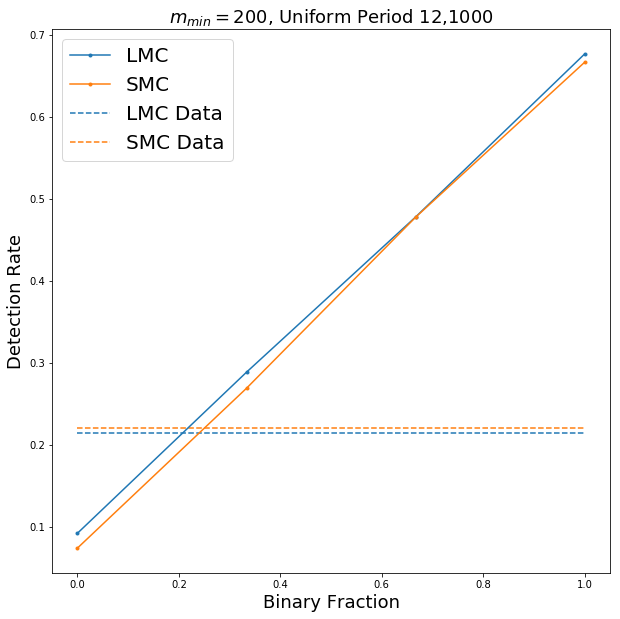

In [40]:
plt.figure(figsize = (10,10))
plt.plot(b_frac, detection_rate_LMC_200_UP,'.-', color = 'C0', label = 'LMC')
plt.hlines(LMC_binary_detection, 0 ,1, color = 'C0', linestyles='dashed', label = 'LMC Data')
plt.plot(b_frac, detection_rate_SMC_200_UP, '.-', color = 'C1', label = 'SMC')
plt.hlines(SMC_binary_detection, 0 ,1, color = 'C1', linestyles='dashed', label = 'SMC Data')
plt.xlabel('Binary Fraction', size = 18)
plt.ylabel('Detection Rate', size = 18)
plt.title('$m_{min} = 200$, Uniform Period 12,1000', size = 18)
plt.legend(prop = {'size': 20})
plt.show()

In [42]:
b_frac = np.linspace(0, 1, 4)
detection_rate_LMC_30_UP = []
for i in b_frac:
    p_value_result_LMC_30_UP, binary_result_LMC_30_UP = thing_LMC.Master(30, True, False, i, 10)
    detection_rate_LMC_30_UP.append(np.count_nonzero(binary_result_LMC_30_UP)/len(binary_result_LMC_30_UP))
    
detection_rate_SMC_30_UP = []
for i in b_frac:
    p_value_result_SMC_30_UP, binary_result_SMC_30_UP = thing_SMC.Master(30, True, False, i, 10)
    detection_rate_SMC_30_UP.append(np.count_nonzero(binary_result_SMC_30_UP)/len(binary_result_SMC_30_UP))

Now I have my synthetic detection rates. I want to do the same detection process but with the real data to see where they intersect.

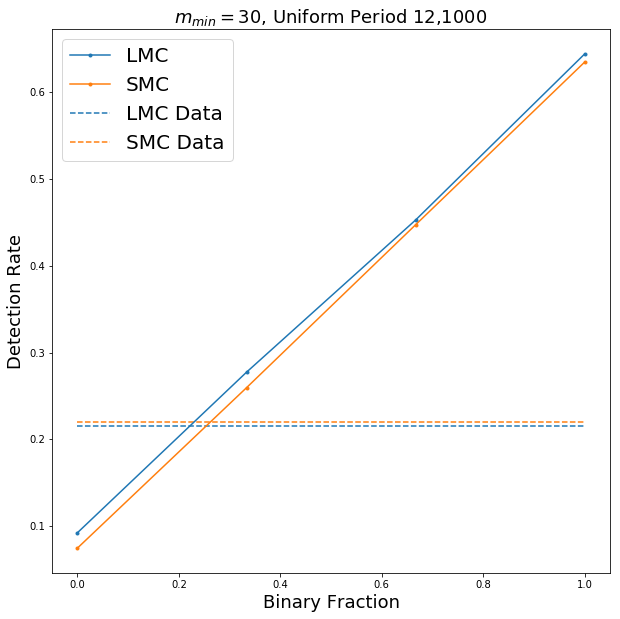

In [44]:
plt.figure(figsize = (10,10))
plt.plot(b_frac, detection_rate_LMC_30_UP,'.-', color = 'C0', label = 'LMC')
plt.hlines(LMC_binary_detection, 0 ,1, color = 'C0', linestyles='dashed', label = 'LMC Data')
plt.plot(b_frac, detection_rate_SMC_30_UP, '.-', color = 'C1', label = 'SMC')
plt.hlines(SMC_binary_detection, 0 ,1, color = 'C1', linestyles='dashed', label = 'SMC Data')
plt.xlabel('Binary Fraction', size = 18)
plt.ylabel('Detection Rate', size = 18)
plt.title('$m_{min} = 30$, Uniform Period 12,1000', size = 18)
plt.legend(prop = {'size': 20})
plt.show()

In [ ]:
b_frac = np.linspace(0, 1, 4)
detection_rate_LMC_30_LNP = []
for i in b_frac:
    p_value_result_LMC_30_LNP, binary_result_LMC_30_LNP = thing_LMC.Master(30, True, False, i, 10)
    detection_rate_LMC_30_LNP.append(np.count_nonzero(binary_result_LMC_30_LNP)/len(binary_result_LMC_30_LNP))
    
detection_rate_SMC_30_LNP = []
for i in b_frac:
    p_value_result_SMC_30_LNP, binary_result_SMC_30_LNP = thing_SMC.Master(30, True, False, i, 10)
    detection_rate_SMC_30_LNP.append(np.count_nonzero(binary_result_SMC_30_LNP)/len(binary_result_SMC_30_LNP))

In [46]:
detection_rate_LMC_200_UP

[0.09184168012924071,
 0.28852988691437803,
 0.47802907915993537,
 0.677140549273021]

In [6]:
thing2

NameError: name 'thing2' is not defined